In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# --- Load Data ---
df = pd.read_csv('trafficpredictiondataset.csv')  # Replace with your dataset filename

In [3]:
df.head()

,timestamp,origin,destination,distance_km,duration_traffic_min,duration_normal_min,congestion_level
0,43:35.0,"Jodhpur, Ahmedabad, India","Prahlad Nagar, Ahmedabad, India",2.2,8,6,Moderate
1,43:45.1,"Navrangpura, Ahmedabad, India","Vastrapur, Ahmedabad, India",4.6,20,12,High
2,43:55.7,"Narol, Ahmedabad, India","Motera, Ahmedabad, India",21.0,56,40,Moderate
3,44:06.2,"Gandhigram, Ahmedabad, India","Memnagar, Ahmedabad, India",6.6,28,17,High
4,44:16.7,"Paldi, Ahmedabad, India","Thaltej, Ahmedabad, India",9.0,41,24,High


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             4019 non-null   object 
 1   origin                4019 non-null   object 
 2   destination           4019 non-null   object 
 3   distance_km           4019 non-null   float64
 4   duration_traffic_min  4019 non-null   int64  
 5   duration_normal_min   4019 non-null   int64  
 6   congestion_level      4019 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 219.9+ KB
None
       distance_km  duration_traffic_min  duration_normal_min
count  4019.000000           4019.000000          4019.000000
mean     10.089052             31.193083            21.099030
std       7.965072             15.861962            11.768725
min       0.300000              1.000000             1.000000
25%       4.600000             21.000000            12.0

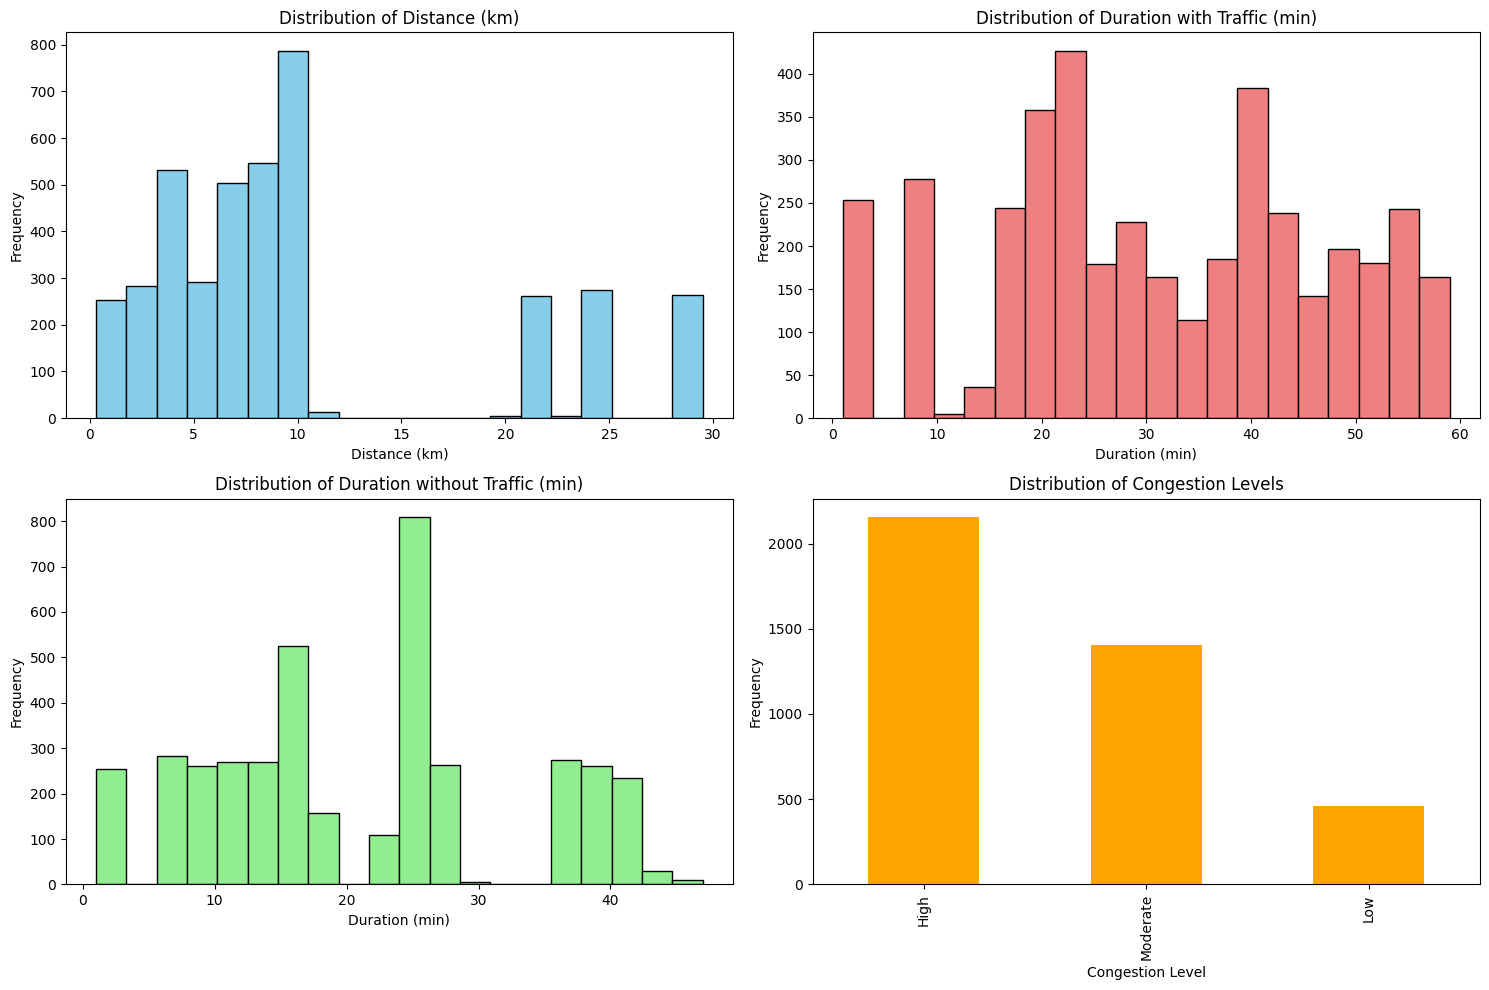

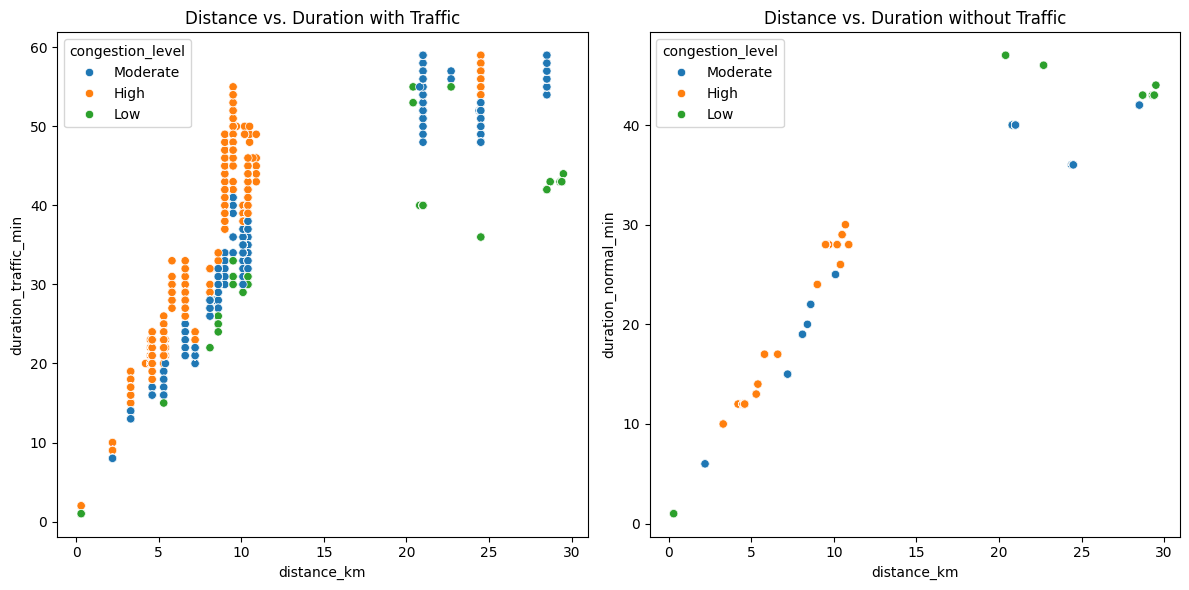

Unique origins: 15
Unique destinations: 15
Most frequent origins:
 origin
Jodhpur, Ahmedabad, India        283
Paldi, Ahmedabad, India          279
Bopal, Ahmedabad, India          275
Nikol, Ahmedabad, India          273
SG Highway, Ahmedabad, India     273
Kankaria, Ahmedabad, India       270
Satellite, Ahmedabad, India      270
Navrangpura, Ahmedabad, India    269
Maninagar, Ahmedabad, India      268
Gandhigram, Ahmedabad, India     265
Name: count, dtype: int64
Most frequent destinations:
 destination
Prahlad Nagar, Ahmedabad, India      283
Thaltej, Ahmedabad, India            279
Chandkheda, Ahmedabad, India         275
Shahibaug, Ahmedabad, India          273
Naroda, Ahmedabad, India             273
Judges Bungalow, Ahmedabad, India    270
Naranpura, Ahmedabad, India          270
Vastrapur, Ahmedabad, India          269
Bapunagar, Ahmedabad, India          268
Memnagar, Ahmedabad, India           265
Name: count, dtype: int64
['Jodhpur, Ahmedabad, India' 'Navrangpura, Ahmedabad,

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Examine Data Types and Summary Statistics
print(df.info())
print(df.describe())

# Check for Missing Values
print(df.isnull().sum())

# Analyze Feature Distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(df['distance_km'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(df['duration_traffic_min'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Duration with Traffic (min)')
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(df['duration_normal_min'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Duration without Traffic (min)')
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
df['congestion_level'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of Congestion Levels')
plt.xlabel('Congestion Level')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Explore Relationships between Features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='distance_km', y='duration_traffic_min', data=df, hue='congestion_level')
plt.title('Distance vs. Duration with Traffic')

plt.subplot(1, 2, 2)
sns.scatterplot(x='distance_km', y='duration_normal_min', data=df, hue='congestion_level')
plt.title('Distance vs. Duration without Traffic')

plt.tight_layout()
plt.show()

# Understand 'origin' and 'destination' features
print("Unique origins:", df['origin'].nunique())
print("Unique destinations:", df['destination'].nunique())
print("Most frequent origins:\n", df['origin'].value_counts().head(10))
print("Most frequent destinations:\n", df['destination'].value_counts().head(10))

#Check for potential typos
print(df['origin'].unique())
print(df['destination'].unique())

In [5]:
# --- Encode Categorical Features ---
le_origin = LabelEncoder()
le_destination = LabelEncoder()
df['origin_encoded'] = le_origin.fit_transform(df['origin'])
df['destination_encoded'] = le_destination.fit_transform(df['destination'])

In [6]:
df.head()

,timestamp,origin,destination,distance_km,duration_traffic_min,duration_normal_min,congestion_level,origin_encoded,destination_encoded
0,43:35.0,"Jodhpur, Ahmedabad, India","Prahlad Nagar, Ahmedabad, India",2.2,8,6,Moderate,6,10
1,43:45.1,"Navrangpura, Ahmedabad, India","Vastrapur, Ahmedabad, India",4.6,20,12,High,10,14
2,43:55.7,"Narol, Ahmedabad, India","Motera, Ahmedabad, India",21.0,56,40,Moderate,9,7
3,44:06.2,"Gandhigram, Ahmedabad, India","Memnagar, Ahmedabad, India",6.6,28,17,High,4,6
4,44:16.7,"Paldi, Ahmedabad, India","Thaltej, Ahmedabad, India",9.0,41,24,High,12,12


In [7]:
# Preprocessing: Convert timestamp to datetime (handling mixed formats)
def parse_timestamp(ts):
    try:
        return pd.to_datetime(ts)  # Try parsing ISO format
    except:
        return pd.to_datetime(f"2025-03-21 {ts}", format="%Y-%m-%d %M:%S.%f", errors='coerce')

df['timestamp'] = df['timestamp'].apply(parse_timestamp)

# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['minute'] = df['timestamp'].dt.minute  # Add this line

In [8]:
df.head()

,timestamp,origin,destination,distance_km,duration_traffic_min,duration_normal_min,congestion_level,origin_encoded,destination_encoded,hour,day_of_week,minute
0,2025-03-21 00:43:35.000,"Jodhpur, Ahmedabad, India","Prahlad Nagar, Ahmedabad, India",2.2,8,6,Moderate,6,10,0,4,43
1,2025-03-21 00:43:45.100,"Navrangpura, Ahmedabad, India","Vastrapur, Ahmedabad, India",4.6,20,12,High,10,14,0,4,43
2,2025-03-21 00:43:55.700,"Narol, Ahmedabad, India","Motera, Ahmedabad, India",21.0,56,40,Moderate,9,7,0,4,43
3,2025-03-21 00:44:06.200,"Gandhigram, Ahmedabad, India","Memnagar, Ahmedabad, India",6.6,28,17,High,4,6,0,4,44
4,2025-03-21 00:44:16.700,"Paldi, Ahmedabad, India","Thaltej, Ahmedabad, India",9.0,41,24,High,12,12,0,4,44


In [9]:
# Clean 'origin' and 'destination' columns
if df is not None:
    for col in ['origin', 'destination']:
        df[col] = df[col].str.lower()
        df[col] = df[col].str.strip()

In [10]:
df.head()

,timestamp,origin,destination,distance_km,duration_traffic_min,duration_normal_min,congestion_level,origin_encoded,destination_encoded,hour,day_of_week,minute
0,2025-03-21 00:43:35.000,"jodhpur, ahmedabad, india","prahlad nagar, ahmedabad, india",2.2,8,6,Moderate,6,10,0,4,43
1,2025-03-21 00:43:45.100,"navrangpura, ahmedabad, india","vastrapur, ahmedabad, india",4.6,20,12,High,10,14,0,4,43
2,2025-03-21 00:43:55.700,"narol, ahmedabad, india","motera, ahmedabad, india",21.0,56,40,Moderate,9,7,0,4,43
3,2025-03-21 00:44:06.200,"gandhigram, ahmedabad, india","memnagar, ahmedabad, india",6.6,28,17,High,4,6,0,4,44
4,2025-03-21 00:44:16.700,"paldi, ahmedabad, india","thaltej, ahmedabad, india",9.0,41,24,High,12,12,0,4,44


In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['congestion_level_encoded'] = encoder.fit_transform(df['congestion_level'])
df = df.drop(['congestion_level'], axis=1)

In [12]:
# --- Select Features and Targets ---
features = df[['origin_encoded', 'destination_encoded','hour','day_of_week','minute']]
targets = df[['congestion_level_encoded', 'distance_km']]

In [13]:
# --- Normalize Features ---
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

In [14]:
# --- Sequence Generator ---
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps].values)
    return np.array(Xs), np.array(ys, dtype=np.float64)

X_seq, y_seq = create_sequences(features_scaled, targets, time_steps=10)

In [15]:
# --- Train-Test Split ---
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [16]:
# --- LSTM Model ---
#model = Sequential()
#model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(2))  # 2 targets: congestion_level, distance

from tensorflow.keras.layers import LSTM, Dense, Dropout
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.003  # Example value, adjust as needed

# Create an Adam optimizer instance with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')

#model.compile(optimizer='adam', loss='mse')
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
# --- Train ---
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 52.0585 - val_loss: 35.0438
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 30.8622 - val_loss: 35.0967
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 30.9670 - val_loss: 35.0857
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 30.7172 - val_loss: 35.1294
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 31.1004 - val_loss: 35.2194
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 32.2466 - val_loss: 35.2450
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 31.7865 - val_loss: 35.3141
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 30.7790 - val_loss: 35.3868
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 31.7081 - val_loss: 35.1522
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 30.8858 - val_loss: 35.1304
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 30.3758 - val_loss: 35.1520
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4

In [19]:
# --- Evaluate ---
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 36.0743
Test Loss: 34.51875305175781


In [20]:
# save the model
model.save('traffic_prediction_model23.h5')